In [1]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hashlib  #主要提供字符加密功能
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
import matplotlib.image as mpimg

# 加载数据集，查看数据集

In [2]:
#下载数据的小函数
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path,"housing.tgz")#路径拼接，压缩文件路径
    urllib.request.urlretrieve(housing_url,tgz_path)#远程数据下载到本地
    housing_tgz = tarfile.open(tgz_path)#指定压缩文件
    housing_tgz.extractall(path=housing_path)#解压到指定文件夹
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
#加载数据小函数
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")#路径拼接，数据文件路径
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
housing.head()#查看数据集顶部5行

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()#查看数据的描述，包括总行数，每个属性的类型和非空值数量

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing["ocean_proximity"].value_counts()#查看该项的类型及数量

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()#展示数值属性的概括

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


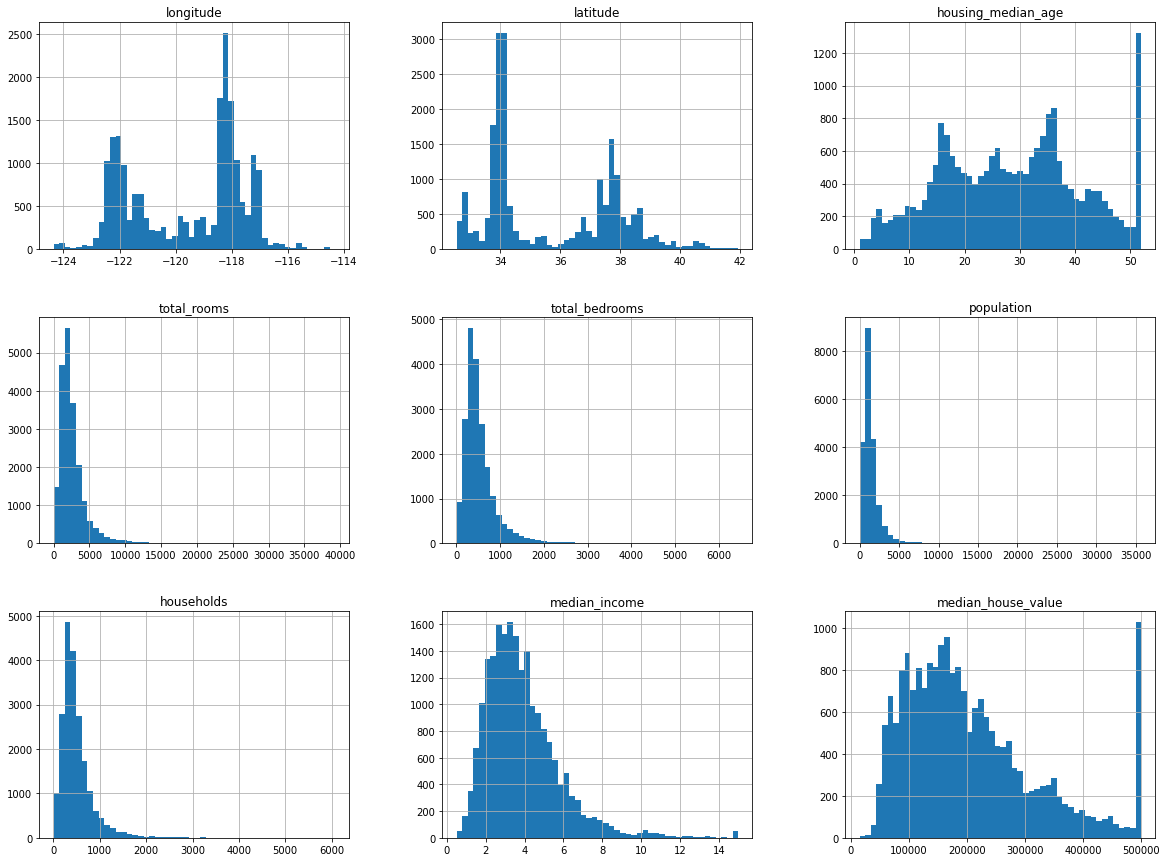

In [9]:
housing.hist(bins=50,figsize=(20,15))#画出每个属性的柱状图
plt.show()

# 创建一个测试集

In [10]:
#分割数据集
def split_train_test(data,test_ratio):
    '''
    data:数据集
    testz-ratio:抽取比例
    '''
    shuffled_indices = np.random.permutation(len(data))#对数组进行重新排序，如果data是多维数组，shuffle只按data的一条轴洗牌，permutation不改变data的顺序
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]#0-抽取数目为止
    train_indices = shuffled_indices[test_set_size:]# 抽取数目到最后
    return data.iloc[train_indices],data.iloc[test_indices]
    

In [11]:
train_set,test_set = split_train_test(housing,0.2)
print(len(train_set),"train +",len(test_set),"test")

16512 train + 4128 test


In [12]:
#为了保证测试集不变，对实例进行识别码判定
'''
hash.digest() 返回摘要，作为二进制数据字符串值
np.int64()强转为int64类型，和int不是一个类型。
apply()  将函数应用到由各列或行形成的数组上
lambda匿名函数 对id_做一个表达式为test_set_check的运算
loc通过标签索引行数据
'''
def test_set_check(identifier,test_ratio,hash):
    '''
    identifier:
    test_ratio:
    hash:
    '''
    return bytearray(hash(np.int64(identifier)).digest())[-1]<256*test_ratio#求出ID哈希值最后一个字节是否满足<256*ratio

def split_train_test_by_id(data,test_ratio,id_column,hash=hashlib.md5):
    '''
    id_column:
    hash:
    '''
    ids = data[id_column] #按索引找出id
    in_test_set = ids.apply(lambda id_: test_set_check(id_,test_ratio,hash))#对所有数据进行划分
    return data.loc[~in_test_set],data.loc[in_test_set]

In [13]:
#使用索引作为识别码
housing_with_id = housing.reset_index()#对housing多维数组,也就是原有数据集前面添加一列序号,标签名是"index"
train_set,test_set = split_train_test_by_id(housing_with_id,0.2,"index")#使用索引作为id进行划分

In [14]:
#使用经纬度作为识别码
housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"]
train_set,test_set = split_train_test_by_id(housing_with_id,0.2,"id")#使用经纬度作为识别码

In [15]:
#使用sklearn的函数
train_set,test_set = train_test_split(housing,test_size=0.2,random_state=42)

In [16]:
#采用分层抽样的，数据集划分
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)#中位数除以1.5，向上取整
housing["income_cat"].where(housing["income_cat"]<5,5.0,inplace=True)#将所有大于5的分类归入到分类

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
#n_splits是将训练数据分成train/test对的组数，test_size是所占比例，random_state控制是将样本随机打乱

for train_index,test_index in split.split(housing,housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
print(housing["income_cat"].value_counts() / len(housing))#查看收入分配比例


3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64


In [17]:
print(housing["income_cat"].value_counts()/len(strat_test_set))

3.0    1.752907
2.0    1.594234
4.0    0.881541
5.0    0.572190
1.0    0.199128
Name: income_cat, dtype: float64


In [18]:
#删除income_cat属性，使数据集回到初始状态
for set in (strat_train_set,strat_test_set):
    set.drop(["income_cat"],axis=1,inplace=True)
    

# 数据可视化

In [19]:
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

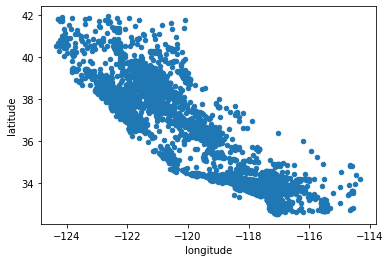

In [20]:
#经纬度画图
housing.plot(kind="scatter",x="longitude",y="latitude")#scatter是散点图的意思

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

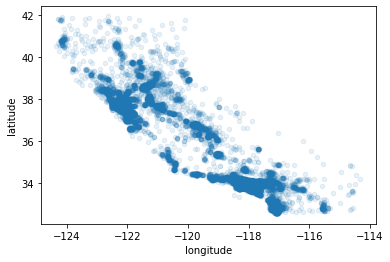

In [21]:
#虚化的经纬度画图
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.1)#alpha是点的透明度

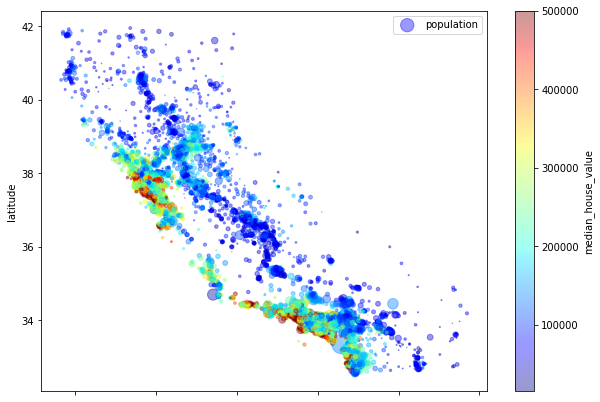

In [22]:
#房价
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,
            s=housing["population"]/100,label="population",figsize=(10,7),
            c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True)#s是点的大小，c是颜色
plt.legend()

In [23]:
#下载加利福尼亚地图
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
IMAGE_PATH = "datasets"
file_name = "california.png"
IMAGE_URL = DOWNLOAD_ROOT + "images/end_to_end_project/" + file_name

if not os.path.isdir(IMAGE_PATH):
    os.makedirs(IMAGE_PATH)
urllib.request.urlretrieve(IMAGE_URL,os.path.join(IMAGE_PATH,file_name))#前一个参数一点也不能动


('datasets\\california.png', <http.client.HTTPMessage at 0x29a29e6de20>)

C:\Users\qingyang\AppData\Local\Temp/ipykernel_8624/3735863928.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)


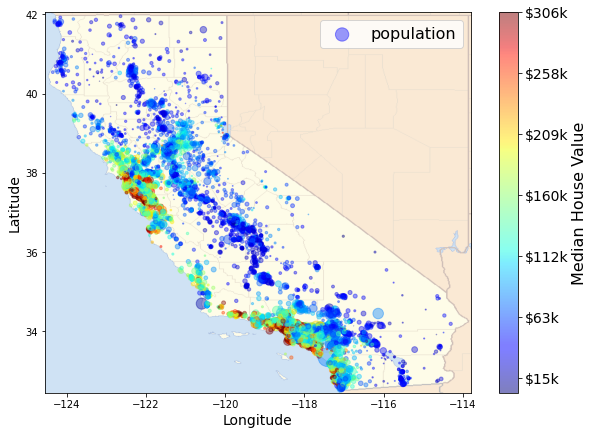

In [31]:
PROJECT_ROOT_DIR = '.'
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/datasets/california.png')
ax = housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,
            s=housing["population"]/100,label="population",figsize=(10,7),
            c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=False)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.savefig("california_housing_prices_plot")
plt.show()

## 查找关联

In [24]:
#用现成的方法测试相关性
corr_matrix = housing.corr()#计算每对属性之间的标准相关系数，也称做皮尔逊相关系数

In [25]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

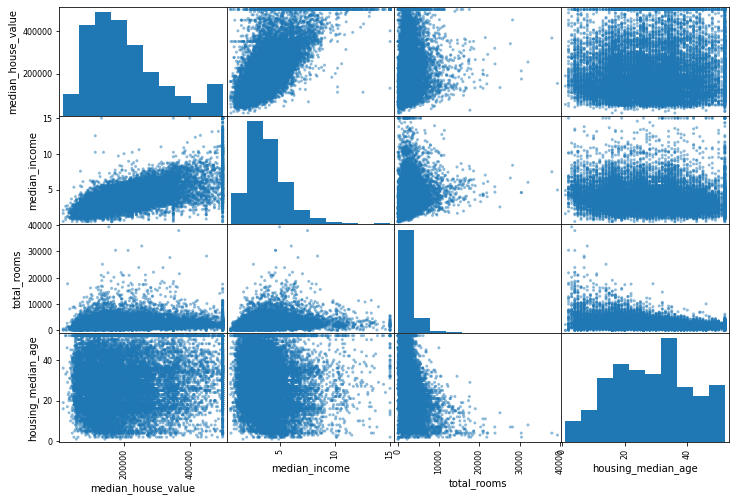

In [26]:
#还是用现成的方法测试相关性
#pandas的scatter_matrix函数
from pandas.plotting import scatter_matrix

attributes = ["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

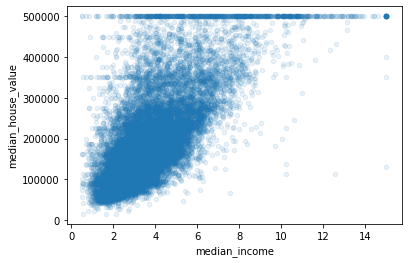

In [27]:
#放大收入中位数的相关性那张图
housing.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1)

## 属性组合实验

In [28]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]= housing["total_bedrooms"]/housing["total_rooms"]
housing["pupulation_per_househole"] = housing["population"]/housing["households"]

In [29]:
#查看新的相关矩阵
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
pupulation_per_househole   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

## 数据清洗

In [30]:
housing = strat_train_set.drop("median_house_value",axis=1)#去除预测量
housing_labels = strat_train_set["median_house_value"].copy()

处理空数据

In [31]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [32]:
#sklearn中有一个Imputer类，可以处理缺失值
#用该属性中位数替换每个缺失值
#这个类有点问题，所以以防万一做一个替换
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")#创建一个实例


In [33]:
housing_num = housing.drop("ocean_proximity",axis=1)#因为只有数值属性才能算出中位数，所以去除文本属性并且保存为一个副本


In [34]:
imputer.fit(housing_num)#用fit()方法将imputer实例拟合到训练数据

SimpleImputer(strategy='median')

In [35]:
imputer.statistics_
#每个属性的中位数保存在statistics_中

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [36]:
housing_num.median().values
#检测是否与每个属性的中位数一致

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

转换训练集 train_set

In [37]:
#将缺失值替换为中位数
X = imputer.transform(housing_num)

In [66]:
housing_tr = pd.DataFrame(X,columns=housing_num.columns,index=housing.index)

In [67]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


处理文本和分类属性

In [40]:
#因为新的ordinalencoder更优秀，所以换新版本，此处与课本不一致
'''try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20'''

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat = housing[['ocean_proximity']]
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded

array([[1.],
       [4.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

In [76]:
#书上原程序
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoderd = encoder.fit_transform(housing_cat)
housing_cat_encoderd


array([1, 4, 1, ..., 0, 0, 1])

In [41]:
ordinal_encoder.categories_#查看映射

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [42]:
#弥补了一些弊端，独热矢量编码
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [43]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [44]:
#简便一点的写法
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

自定义转换类型

In [54]:
#自定义了上面的，转换训练集的办法，就是增加了几个属性及其数据
from sklearn.base import BaseEstimator,TransformerMixin
rooms_ix,bedrooms_ix,population_ix,household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self,X,y = None):
        return self
    def transform(self,X,y=None):
        rooms_per_household = X[:,rooms_ix]/X[:,household_ix]
        population_per_household = X[:,population_ix]/X[:,household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [55]:
housing_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 'INLAND', 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 'NEAR OCEAN', 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 'INLAND', 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., '<1H OCEAN', 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., '<1H OCEAN', 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 'INLAND', 5.477157360406092,
        3.1725888324873095]], dtype=object)

In [56]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs,columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
                                     index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


特征缩放

包括，归一化方法或者标准化方法

转换Pipeline

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('attribs_adder',CombinedAttributesAdder(add_bedrooms_per_room=True)),
    ('std_scaler',StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [72]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [73]:
#一个完整的处理数值和分类属性的pipeline
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [74]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [75]:
housing_prepared.shape

(16512, 16)

## 选择一个模型并训练

In [76]:
#线性回归模型
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

LinearRegression()

In [81]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("predictions:\t",lin_reg.predict(some_data_prepared))
print("Labels:\t\t",list(some_labels))

predictions:	 [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels:		 [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [83]:
#计算误差
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels,housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

In [85]:
#决策树模型
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_labels)

DecisionTreeRegressor()

In [86]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels,housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [87]:
#交叉验证
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [88]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72172.16468031 69419.95791689 68790.75410663 70659.88657283
 70398.69217793 77666.01046011 71415.90020764 72916.89474315
 68183.22702843 71527.73930048]
Mean: 71315.1227194398
Standard deviation: 2544.2359959831724


In [89]:
#计算线性回归的部分，交叉验证
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180675


In [90]:
#随机森林模型
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(n_estimators=10, random_state=42)

In [91]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22413.454658589766

In [92]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [53519.05518628 50467.33817051 48924.16513902 53771.72056856
 50810.90996358 54876.09682033 56012.79985518 52256.88927227
 51527.73185039 55762.56008531]
Mean: 52792.92669114079
Standard deviation: 2262.8151900582


模型微调

In [93]:
#网格搜索
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [94]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [95]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [96]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63895.161577951665 {'max_features': 2, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'n_estimators': 10}
52885.86715332332 {'max_features': 2, 'n_estimators': 30}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'n_estimators': 30}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
49969.80441627874 {'max_features': 6, 'n_estimators': 30}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
49898.98913455217 {'max_features': 8, 'n_estimators': 30}
62381.765106921855 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54476.57050944266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59974.60028085155 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52754.5632813202 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

In [97]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.96542523e-02, 6.04213840e-02, 4.21882202e-02, 1.52450557e-02,
       1.55545295e-02, 1.58491147e-02, 1.49346552e-02, 3.79009225e-01,
       5.47789150e-02, 1.07031322e-01, 4.82031213e-02, 6.79266007e-03,
       1.65706303e-01, 7.83480660e-05, 1.52473276e-03, 3.02816106e-03])

In [98]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3790092248170967, 'median_income'),
 (0.16570630316895876, 'INLAND'),
 (0.10703132208204355, 'pop_per_hhold'),
 (0.06965425227942929, 'longitude'),
 (0.0604213840080722, 'latitude'),
 (0.054778915018283726, 'rooms_per_hhold'),
 (0.048203121338269206, 'bedrooms_per_room'),
 (0.04218822024391753, 'housing_median_age'),
 (0.015849114744428634, 'population'),
 (0.015554529490469328, 'total_bedrooms'),
 (0.01524505568840977, 'total_rooms'),
 (0.014934655161887772, 'households'),
 (0.006792660074259966, '<1H OCEAN'),
 (0.0030281610628962747, 'NEAR OCEAN'),
 (0.0015247327555504937, 'NEAR BAY'),
 (7.834806602687504e-05, 'ISLAND')]

In [99]:
#用测试集评估系统
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [100]:
final_rmse

47873.26095812988